** Chapter 9!! 

## Using TensorBoard

In [ ]:
#import necessary things

In [1]:
import tensorflow as tf

import numpy as np

In [2]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [8]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

Import data 

In [9]:
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]


To implement manin batch Gradient Descent.

change the definition of X and y in the construction phase to make them placeholder nodes

In [11]:

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [12]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [13]:
n_epochs = 100
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

fetch the mini batches one by one, then provide the value of X and y via the feed_dict parameter when evaluating a node that depends on either of them

In [14]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    #random int (m to batch_size )
    
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

In [15]:
with tf.Session() as sess:                                                        # not shown in the book
    sess.run(init)                                                                # not shown

    for epoch in range(n_epochs):                                                 # not shown
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                     # not shown

In [16]:
file_writer.close()

In [17]:
best_theta

array([[ 2.0544672 ],
       [ 0.82970113],
       [ 0.10713524],
       [-0.31074819],
       [ 0.24564511],
       [-0.00222412],
       [-0.01061389],
       [-0.89121586],
       [-0.87524796]], dtype=float32)

`

# Name scopes

When dealing with more complex models such as neural networks, the graph can easily become cluttered with thousands of nodes. 

You can create name scopes to group related nodes. 

### Modify the previous code to define the error and mse ops within a name scope called "loss" ~~~~~~

In [19]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [20]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [22]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.07033372]
 [ 0.86371452]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.80304712]]


In [23]:
print(error.op.name)

loss/sub


In [24]:
print(mse.op.name)

loss/mse


In [25]:
reset_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# Exercise solutions

## 12. Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

First, let's create the moons dataset using Scikit-Learn's `make_moons()` function:

In [28]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

Let's take a peek at the dataset:

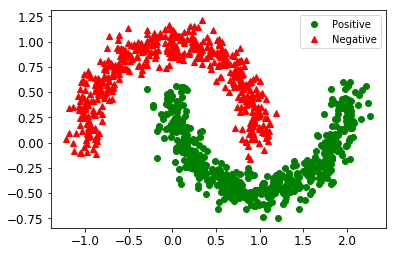

In [29]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

We must not forget to add an extra bias feature ($x_0 = 1$) to every instance. For this, we just need to add a column full of 1s on the left of the input matrix $\mathbf{X}$:

In [30]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

Let's check:

In [31]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

Looks good. Now let's reshape `y_train` to make it a column vector (i.e. a 2D array with a single column):

In [32]:
y_moons_column_vector = y_moons.reshape(-1, 1)

In [35]:
y_moons_column_vector[:20]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

Now let's split the data into a training set and a test set:

In [36]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

Ok, now let's create a small function to generate training batches. In this implementation we will just pick random instances from the training set for each batch. This means that a single batch may contain the same instance multiple times, and also a single epoch may not cover all the training instances (in fact it will generally cover only about two thirds of the instances). However, in practice this is not an issue and it simplifies the code:

In [37]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

Let's look at a small batch:

In [38]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.93189866,  0.13158788],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -1.01148674, -0.04686381],
       [ 1.        ,  0.02201868,  0.19079139],
       [ 1.        , -0.98941204,  0.02473116]])

In [39]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Great! Now that the data is ready to be fed to the model, we need to build that model. Let's start with a simple implementation, then we will add all the bells and whistles.

First let's reset the default graph.

In [40]:
reset_graph()

The _moons_ dataset has two input features, since each instance is a point on a plane (i.e., 2-Dimensional):

In [41]:
n_inputs = 2

Now let's build the Logistic Regression model. As we saw in chapter 4, this model first computes a weighted sum of the inputs (just like the Linear Regression model), and then it applies the sigmoid function to the result, which gives us the estimated probability for the positive class:

$\hat{p} = h_\mathbf{\theta}(\mathbf{x}) = \sigma(\mathbf{\theta}^T \cdot \mathbf{x})$


Recall that $\mathbf{\theta}$ is the parameter vector, containing the bias term $\theta_0$ and the weights $\theta_1, \theta_2, \dots, \theta_n$. The input vector $\mathbf{x}$ contains a constant term $x_0 = 1$, as well as all the input features $x_1, x_2, \dots, x_n$.

Since we want to be able to make predictions for multiple instances at a time, we will use an input matrix $\mathbf{X}$ rather than a single input vector. The $i^{th}$ row will contain the transpose of the $i^{th}$ input vector $(\mathbf{x}^{(i)})^T$. It is then possible to estimate the probability that each instance belongs to the positive class using the following equation:

$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \cdot \mathbf{\theta})$

That's all we need to build the model:

In [42]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits))

In fact, TensorFlow has a nice function `tf.sigmoid()` that we can use to simplify the last line of the previous code:

In [43]:
y_proba = tf.sigmoid(logits)

As we saw in chapter 4, the log loss is a good cost function to use for Logistic Regression:

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$

One option is to implement it ourselves:

In [44]:
epsilon = 1e-7  # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

But we might as well use TensorFlow's `tf.losses.log_loss()` function:

In [45]:
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

The rest is pretty standard: let's create the optimizer and tell it to minimize the cost function:

In [46]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

All we need now (in this minimal version) is the variable initializer:

In [47]:
init = tf.global_variables_initializer()

And we are ready to train the model and use it for predictions!

There's really nothing special about this code, it's virtually the same as the one we used earlier for Linear Regression:

In [48]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.792602
Epoch: 100 	Loss: 0.343463
Epoch: 200 	Loss: 0.30754
Epoch: 300 	Loss: 0.292889
Epoch: 400 	Loss: 0.285336
Epoch: 500 	Loss: 0.280478
Epoch: 600 	Loss: 0.278083
Epoch: 700 	Loss: 0.276154
Epoch: 800 	Loss: 0.27552
Epoch: 900 	Loss: 0.274912


Note: we don't use the epoch number when generating batches, so we could just have a single `for` loop rather than 2 nested `for` loops, but it's convenient to think of training time in terms of number of epochs (i.e., roughly the number of times the algorithm went through the training set).

For each instance in the test set, `y_proba_val` contains the estimated probability that it belongs to the positive class, according to the model. For example, here are the first 5 estimated probabilities:

In [49]:
y_proba_val[:5]

array([[ 0.54895616],
       [ 0.70724374],
       [ 0.51900256],
       [ 0.9911136 ],
       [ 0.50859052]], dtype=float32)

To classify each instance, we can go for maximum likelihood: classify as positive any instance whose estimated probability is greater or equal to 0.5:

In [50]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision). See chapter 3 for more details.

Let's compute the model's precision and recall:

In [51]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.86274509803921573

In [52]:
recall_score(y_test, y_pred)

0.88888888888888884

Let's plot these predictions to see what they look like:

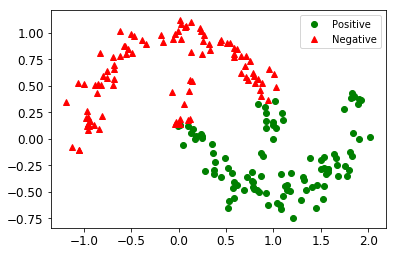

In [53]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Well, that looks pretty bad, doesn't it? But let's not forget that the Logistic Regression model has a linear decision boundary, so this is actually close to the best we can do with this model (unless we add more features, as we will show in a second).

Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:
* Define the graph within a `logistic_regression()` function that can be reused easily.
* Save checkpoints using a `Saver` at regular intervals during training, and save the final model at the end of training.
* Restore the last checkpoint upon startup if training was interrupted.
* Define the graph using nice scopes so the graph looks good in TensorBoard.
* Add summaries to visualize the learning curves in TensorBoard.
* Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Before we start, we will add 4 more features to the inputs: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ and ${x_2}^3$. This was not part of the exercise, but it will demonstrate how adding features can improve the model. We will do this manually, but you could also add them using `sklearn.preprocessing.PolynomialFeatures`.

In [54]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

This is what the "enhanced" training set looks like:

In [55]:
X_train_enhanced[:5]

array([[  1.00000000e+00,  -5.14696757e-02,   4.44198631e-01,
          2.64912752e-03,   1.97312424e-01,  -1.36349734e-04,
          8.76459084e-02],
       [  1.00000000e+00,   1.03201691e+00,  -4.19741157e-01,
          1.06505890e+00,   1.76182639e-01,   1.09915879e+00,
         -7.39511049e-02],
       [  1.00000000e+00,   8.67891864e-01,  -2.54827114e-01,
          7.53236288e-01,   6.49368582e-02,   6.53727646e-01,
         -1.65476722e-02],
       [  1.00000000e+00,   2.88850997e-01,  -4.48668621e-01,
          8.34348982e-02,   2.01303531e-01,   2.41002535e-02,
         -9.03185778e-02],
       [  1.00000000e+00,  -8.33439108e-01,   5.35056649e-01,
          6.94620746e-01,   2.86285618e-01,  -5.78924095e-01,
          1.53179024e-01]])

Ok, next let's reset the default graph:

In [56]:
reset_graph()

Now let's define the `logistic_regression()` function to create the graph. We will leave out the definition of the inputs `X` and the targets `y`. We could include them here, but leaving them out will make it easier to use this function in a wide range of use cases (e.g. perhaps we will want to add some preprocessing steps for the inputs before we feed them to the Logistic Regression model).

In [57]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a little function to get the name of the log directory to save the summaries for Tensorboard:

In [58]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Next, let's create the graph, using the `logistic_regression()` function. We will also create the `FileWriter` to save the summaries to the log directory for Tensorboard:

In [59]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

At last we can train the model! We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example we just save the epoch number to a separate file, but in chapter 11 we will see how to store the training step directly as part of the model, using a non-trainable variable called `global_step` that we pass to the optimizer's `minimize()` method.

You can try interrupting training to verify that it does indeed restore the last checkpoint when you start it again.

In [60]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.161224
Epoch: 1000 	Loss: 0.119032
Epoch: 1500 	Loss: 0.0973292
Epoch: 2000 	Loss: 0.0836979
Epoch: 2500 	Loss: 0.0743758
Epoch: 3000 	Loss: 0.0675021
Epoch: 3500 	Loss: 0.0622069
Epoch: 4000 	Loss: 0.0580268
Epoch: 4500 	Loss: 0.054563
Epoch: 5000 	Loss: 0.0517083
Epoch: 5500 	Loss: 0.0492377
Epoch: 6000 	Loss: 0.0471673
Epoch: 6500 	Loss: 0.0453766
Epoch: 7000 	Loss: 0.0438187
Epoch: 7500 	Loss: 0.0423742
Epoch: 8000 	Loss: 0.0410892
Epoch: 8500 	Loss: 0.0399709
Epoch: 9000 	Loss: 0.0389202
Epoch: 9500 	Loss: 0.0380107
Epoch: 10000 	Loss: 0.0371557


Once again, we can make predictions by just classifying as positive all the instances whose estimated probability is greater or equal to 0.5:

In [61]:
y_pred = (y_proba_val >= 0.5)

In [62]:
precision_score(y_test, y_pred)

0.97979797979797978

In [63]:
recall_score(y_test, y_pred)

0.97979797979797978

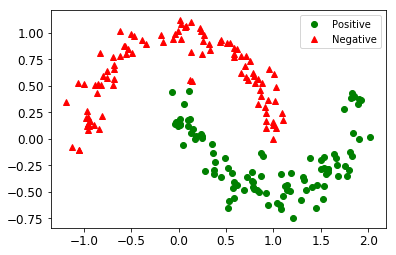

In [64]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Now that's much, much better! Apparently the new features really helped a lot.

Try starting the tensorboard server, find the latest run and look at the learning curve (i.e., how the loss evaluated on the test set evolves as a function of the epoch number):

```
$ tensorboard --logdir=tf_logs
```

Now you can play around with the hyperparameters (e.g. the `batch_size` or the `learning_rate`) and run training again and again, comparing the learning curves. You can even automate this process by implementing grid search or randomized search. Below is a simple implementation of a randomized search on both the batch size and the learning rate. For the sake of simplicity, the checkpoint mechanism was removed.

In [ ]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/logreg-run-20170703132645/
  batch size: 54
  learning_rate: 0.00443037524522
  training: ............